In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from pymc import *
import pymcmcstat
from girth_mcmc import GirthMCMC

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [81]:
sklearn.__version__

'1.2.0'

In [82]:
def despine(axs):
    # to be able to handle subplot grids
    # it assumes the input is a list of
    # axes instances, if it is not a list,
    # it puts it in one
    
    if type(axs) != type([]):
        axs = [axs]
    for ax in axs:
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('outward', 10))
        ax.spines['left'].set_position(('outward', 10))

Text(0.5, 1.0, 'CO$_2$ growth rate')

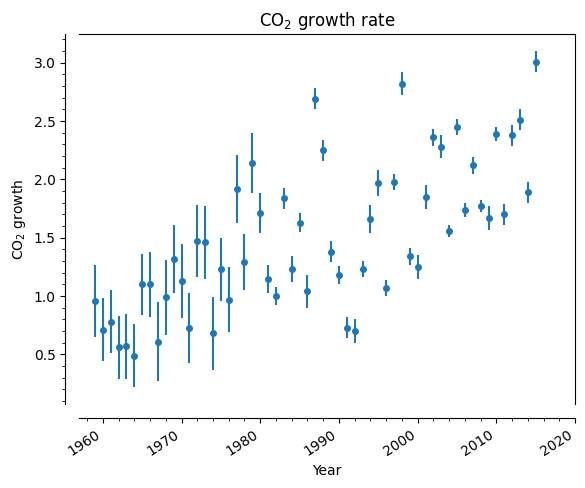

In [83]:
#Linear Regression-Climate Data
co2_gr = pd.read_csv('co2_gr_gl.txt', delim_whitespace=True, skiprows=62, names=['year','rate','err'])
fig, ax = plt.subplots(1,1)
ax.errorbar(co2_gr['year'], co2_gr['rate'], yerr=co2_gr['err'], ls='None', elinewidth=1.5, capthick=1.5, marker='.', ms=8)
despine(ax)
plt.minorticks_on()
labels = ax.get_xticklabels()
plt.setp(labels, rotation=33, ha='right')
ax.set_ylabel('CO$_2$ growth')
ax.set_xlabel('Year')
ax.set_xlim((1957,2020))
ax.set_title('CO$_2$ growth rate')

In [84]:
x_test, x_train, y_test, y_train = train_test_split(
co2_gr['year'], co2_gr['rate'],test_size=0.75,random_state=0)

In [85]:
X_train = x_train[:, np.newaxis]
X_test = x_test[:, np.newaxis]
line_x = np.array([1955, 2025])

/tmp/ipykernel_3104/219447950.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X_train = x_train[:, np.newaxis]
/tmp/ipykernel_3104/219447950.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X_test = x_test[:, np.newaxis]


In [86]:
est_lin = LinearRegression()
est_lin.fit(X_train, y_train)
lin_pred = est_lin.predict(line_x.reshape(-1,1))


In [87]:
est_lasso = Lasso(alpha=0.7)
est_lasso.fit(X_train, y_train)
lasso_pred = est_lasso.predict(line_x.reshape(2, 1))

In [88]:
def printstuff(estimator, A, b):
    name = estimator.__str__().split('(')[0]
    print('+'*6, name, '+'*6)
    print('Slope:{0:.3f} Intercept:{1:.2f} '.format(estimator.coef_[0], estimator.intercept_))
    print("Mean squared residuals: {0:.2f}".format(np.mean((estimator.predict(A) - b) **2)))
    print('Variance score: {0:.2f}'.format(estimator.score(A,b)))
    
printstuff(est_lin, X_test, y_test)
printstuff(est_lasso, X_test, y_test)

++++++ LinearRegression ++++++
Slope:0.027 Intercept:-51.60 
Mean squared residuals: 0.17
Variance score: 0.56
++++++ Lasso ++++++
Slope:0.024 Intercept:-46.16 
Mean squared residuals: 0.17
Variance score: 0.56


Text(0.5, 1.0, 'CO$_2$ growth rate')

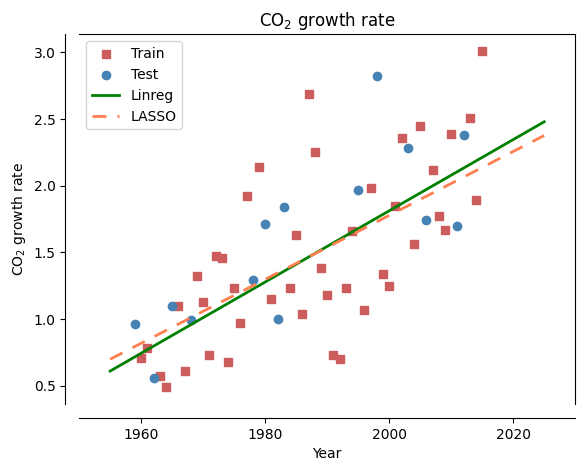

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_train, y_train, marker='s', label='Train', color='IndianRed')
ax.scatter(X_test, y_test, label='Test', color='SteelBlue')
ax.plot(line_x, lin_pred, color='Green',label='Linreg', lw=2)
ax.plot(line_x, lasso_pred, color='Coral',dashes=(5,4), label='LASSO', lw=2)
ax.set_xlabel('Year')
ax.set_ylabel('CO$_2$ growth rate')
ax.legend(loc=2, fontsize=10, numpoints=1)
despine(ax)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=7)
ax.set_xlim(1950, 2030)
ax.set_title('CO$_2$ growth rate')

In [90]:
r2_lin = r2_score(co2_gr['rate'],est_lin.predict(co2_gr['year'].values.reshape(-1,1)))
r2_lasso = r2_score(co2_gr['rate'], est_lasso.predict(co2_gr['year'].values.reshape(-1,1)))
print('LinearSVC: {0:.2f}\nLASSO:\t {1:.2f}'.format(r2_lin, r2_lasso))


LinearSVC: 0.49
LASSO:	 0.48


Checking with Bayesian analysis and OLS

In [119]:
import pymc
x = co2_gr['year'].values
y = co2_gr['rate'].values
y_error = co2_gr['err'].values

def model(x, y):
    slope = pymc.Normal('slope', 0.1,1.)
    intercept = pymc.Normal('intercept', -50., 10.)
    @pymc.deterministic(plot=False)
    def linear(x=x, slope=slope, intercept=intercept):
        return x * slope + intercept
    f = pymc.Normal('f', mu=linear, tau=1.0/y_error, value=y, observed=True)
    return locals()

MDL = pymc.MCMC(model(x,y))
MDL.sample(5e5, 5e4, 100)
y_fit = MDL.stats()['linear']['mean']
slope = MDL.stats()['slope']['mean']
intercept = MDL.stats()['intercept']['mean']


AttributeError: module 'pymc' has no attribute 'MCMC'

In [121]:
ols_results = smf.ols("rate ~ year", co2_gr).fit()
ols_params = np.flipud(ols_results.params)

In [122]:
print('     Slope Intercept\nML: {0:.3f} {1:.3f} \nOLS:{2:.3f} {3:.3f}\nBay: {4:.3f} {5:.3f}'.format(est_lin.coef_[0], est_lin.intercept_, ols_params[0], ols_params[1], slope, intercept))


NameError: name 'slope' is not defined

NameError: name 'y_fit' is not defined

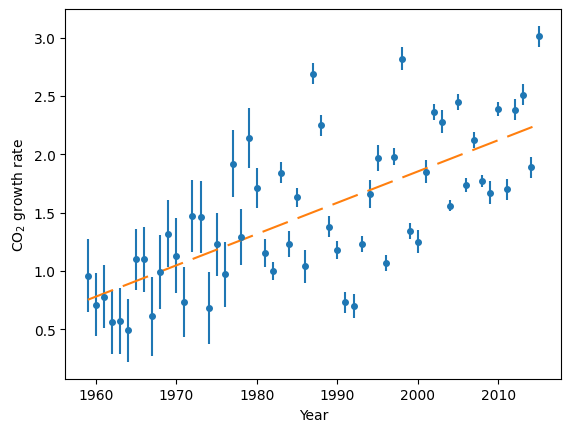

In [123]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x, y, yerr=y_error, ls='None', elinewidth=1.5, capthick=1.5,marker='.', ms=8, label='Observed')
ax.set_xlabel('Year')
ax.set_ylabel('CO$_2$ growth rate')
ax.plot([x.min(), x.max()], [ols_results.fittedvalues.min(), ols_results.fittedvalues.max()], lw=1.5, label='OLS', dashes=(13,5))
ax.plot(x, y_fit, lw=1.5, label='pymc')
ax.plot([x.min(), x.max()],
est_lin.predict([[x.min(), ], [x.max(), ]]),
label='Scikit-learn', lw=1.5)
despine(ax)
ax.locator_params(axis='x', nbins=7)
ax.locator_params(axis='y', nbins=4)
ax.set_xlim((1955,2018))
ax.legend(loc=2, numpoints=1)
ax.set_title('CO$_2$ growth rate')